### Credits: Exercises are made with inspiration from the [DTU-deep-learning](https://github.com/DeepLearningDTU/02456-deep-learning-with-PyTorch/blob/master/4_Convolutional/4.1-CNN-Introduction.ipynb) and [PyTorch Tutorials](https://pytorch.org/tutorials/).


---



# Introduction to Convolutional Neural Networks

This exercise will introduce Convolutional Neural Networks in Pytorch. An important part of the exercise is to read and understand the PyTorch syntax and how, e.g., training loops are structured.
You also have to implement your own CNN for classification :-)

In [ ]:
# Later in the exercise, you will have to download the CIFAR-10 data-set. It might take a while,
# so it would be a good idea to run this cell to start downloading the data already now.
import torchvision
torchvision.datasets.CIFAR10(root='./data', download=True)

100%|██████████| 170498071/170498071 [00:02<00:00, 66628777.71it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train

# Exercise 1:

### Exercise 1.1: Convolve manually

Perform the following calculations by hand, and write the result below. You decide if you want to make a convolution or correlation.


<img src="https://nextcloud.theailab.dk/s/fCF7XZktJDwYA4C/download/inputKernel.jpg" alt="Kernel" style="width:300px;"/>


1. Manually convolve the input with the kernel, and write down the result. Use no padding and stride of 1.
1. Perform $2\times2$ max pooling on the output of the convolution. Use a stride of 2.

Image:
\begin{bmatrix}
1 & 0 & 0 & 0 \\
3 & 0 & 0 & 0 \\
3 & 3 & 0 & 0 \\
4 & 2 & 2 & 2
\end{bmatrix}

Kernel:
\begin{bmatrix}
0 & 0 & 0 \\
2 & 1 & 0 \\
3 & 2 & 2
\end{bmatrix}


**Answer:** Please write your answer in the empty matrix:

\begin{array}{|c|c|}
\hline
     ~ & ~ \\\hline
     ~ & ~ \\\hline
\end{array}



### Exercise 1.2: Calculate output sizes of convolution output

In the following list, you will be given a 3D tensor and some filters. Based on their sizes, calculate the size of the output (if valid). We will use PyTorch notation of dimensions. This means that dimensions are given as channel-first. I.e.: `(channel, height, width)`.

The size of the 3D tensor input is givens as `(channel, height, width)`.
A number `(channels_out)` of filters, have a size of `(channels_in, filter_height, filter_width)`, stride `(height, width)` and padding `(height, width)`.


1. input tensor with dimensionality (1, 28, 28) and 16 filters of size (1, 5, 5) with stride (1, 1) and padding (0, 0)

    **Answer:**

2. input tensor with dimensionality (3, 32, 32) and 24 filters of size (3, 3, 3) with stride (1, 1) and padding (0, 0)

    **Answer:**

3. input tensor with dimensionality (40, 32, 32) and 3 filters of size (40, 2, 2) with stride (2, 2) and padding (0, 0)

     **Answer:**

4. input tensor with dimensionality (11, 8, 16) and 7 filters of size (11, 3, 3) with stride (2, 2) and padding (1, 1)

    **Answer:**

5. input tensor with dimensionality (128, 256, 256) and 112 filters of size (128, 3, 3) with stride (1, 1) and padding (1, 1)

    **Answer:**


### Exercise 1.3: Associative property of convolution
Assume that we have two convolution kernels of size k1 and k2, respectively (with no nonlinearity in-between). The kernels are applied one after the other. Note that to prove associativity you will have to use convolution with the "full" padding scheme, not "valid" or "same". As a practical matter, use the definition of 2d convolution from the slides.:
  1. Prove that the result of the operation can be expressed by a single convolution.
  2. What is the dimensionality of the equivalent single convolution?
  3. Is the converse true, i.e., can you always decompose a convolution into two smaller ones?

# Exercise 2: Creating a convolutional neural network

In this exercise, we will once again train a network to recognize MNIST digits.
First, we will set up the data and the network. Please spend some time reading and understanding the code. Problems are defined at the buttom of the section.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

## Data: MNIST

This code prepares MNIST and sets dimensions to `(num_samples, num_channels, height, width)`, as PyTorch expects.

In [ ]:
from mlxtend.data import mnist_data
X, y = mnist_data()
X = (X/255.0).astype(np.float32) # Convert to interval 0:1
y = y.astype(np.float32)
num_classes = 10
nchannels, rows, cols = 1, 28, 28

X = np.expand_dims(X.reshape(len(X),rows,cols),1) # Add a channel-dimension

Split data in train, validation, and test

In [ ]:
def splitdata(X, y, Ngroups, weights=None):
    '''
    X, y = input data and labels
    Ngroups = number of groups to split data into
    weights = a list with Ngroups weights, that tell the probability of a sample ending in either of the data sets
    '''
    if weights is None:
        weights = [1/Ngroups]*Ngroups

    groups = np.array(random.choices(list(range(Ngroups)), weights=weights, cum_weights=None, k=len(X)))
    return ((X[np.where(groups==g)], y[np.where(groups==g)]) for g in np.array(range(Ngroups)))

(x_train, targets_train), (x_valid, targets_valid), (x_test, targets_test) = splitdata(X, y, Ngroups=3, weights=[0.8, 0.1, 0.1])

## Let's plot some samples from the training set.

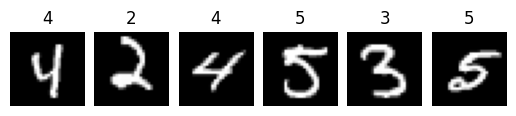

In [ ]:
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure()
nrows_ncols=(1, 6)
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=nrows_ncols,  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for ax, idx in zip(grid, np.random.randint(low=0, high=len(x_train), size=np.prod(nrows_ncols))):
    # Iterating over the grid returns the Axes.
    ax.imshow(X[idx].reshape(28,28), cmap='gray')
    ax.set_title(str(int(y[idx])))
    ax.set_axis_off()

# Define a simple feed forward neural network without convolutions

In [ ]:
import torch
from torch.nn.parameter import Parameter
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init

from torch.nn import Linear, Conv2d, BatchNorm2d, MaxPool2d, Dropout2d
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax

We'll use the nn.Module class to define our network. It will help us create clearer and more compact code by encapsulating the network in a class. It also helps us, if we want to save our trained weights and load them again.

Everything that contains weights, which you want to be trained during the training process should be defined in your \_\_init\_\_ method.

You can read more about the nn.Module class here:
https://pytorch.org/tutorials/beginner/nn_tutorial.html

In [ ]:
# hyperameters of the model
num_classes = 10
channels = x_train.shape[1]
height = x_train.shape[2]
width = x_train.shape[3]


# define network
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        # YOUR CODE BEGINS HERE
        # Define the needed Conv-layer(s)
        # YOUR CODE ENDS HERE
        self.flatten = nn.Flatten()
        self.FC1 = nn.Linear(height*width, 512)
        self.FC2 = nn.Linear(512, num_classes)


    def forward(self, x):
        # YOUR CODE BEGINS HERE
        # Define your network architecture
        x = self.flatten(x)
        x = self.FC1(x)
        x = F.relu(x)
        x = self.FC2(x)
        # YOUR CODE ENDS HERE
        return x

net = NeuralNetwork()
print(net)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (FC1): Linear(in_features=784, out_features=512, bias=True)
  (FC2): Linear(in_features=512, out_features=10, bias=True)
)


## Setting up loss function and optimizer

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001)

We can test our architecture by forwarding random data through it

In [ ]:
x = np.random.randn(3, 1, 28, 28).astype('float32')
out = net(torch.from_numpy(x))
print('Output shape:', out.shape)
print('Output tensor:')
out

Output shape: torch.Size([3, 10])
Output tensor:


tensor([[-0.0288,  0.2087, -0.2222,  0.0638,  0.1743,  0.0717,  0.2504, -0.3498,
          0.1601,  0.2289],
        [ 0.1721,  0.1481, -0.2991,  0.4318, -0.1092,  0.2002,  0.4134,  0.0089,
         -0.2207, -0.0026],
        [ 0.2960, -0.1185,  0.0208,  0.2388,  0.1184,  0.1571,  0.3633, -0.0994,
          0.3004,  0.0432]], grad_fn=<AddmmBackward0>)

Notice how the default weight initialization distributes the output scores nicely between the classes.

## Now we set up the training loop.
Notice that we don't use dataloaders, since writing the training loop manually gives a better understanding of what is going on.
Please spend some time going through the following code-block line-by-line

In [ ]:
batch_size = 100
num_epochs = 100
num_samples_train = x_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = x_valid.shape[0]
num_batches_valid = num_samples_valid // batch_size

train_acc, train_loss = [], []
valid_acc, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
losses = []

def get_slice(i, size):
    return range(i * size, (i + 1) * size)

def accuracy_score(targets, predictions):
    return 1.0*np.sum((np.array(targets) == np.array(predictions)))/len(targets)



# This function iterates through all batches of a dataset, X_data and returns predictions and matching targets
def evaluateLoop(X_data, targets, num_batches):
    allTargets, allPredictions = [], []

    #Iterate through the batches
    for i in range(num_batches):
        slce = get_slice(i, batch_size)
        x_batch = torch.from_numpy(X_data[slce])

        output = net(x_batch)
        predictions = torch.max(output, 1)[1]

        allTargets += list(targets[slce])
        allPredictions += list(predictions.data.numpy())

    return allTargets, allPredictions


for epoch in range(num_epochs):

    ## Train
    cur_loss = 0
    net.train()

    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        x_batch = torch.from_numpy(x_train[slce])
        output = net(x_batch) # Forward pass

        # compute gradients given loss
        target_batch = torch.from_numpy(targets_train[slce]).long()
        batch_loss = criterion(output, target_batch) # Calculate loss
        optimizer.zero_grad() # Reset gradients
        batch_loss.backward() # Backprobagation
        optimizer.step() # Update parameters

        cur_loss += batch_loss
    losses.append(cur_loss / batch_size)

    net.eval()

    ### Evaluate training data
    train_targs, train_preds = evaluateLoop(X_data=x_train, targets=targets_train, num_batches=num_batches_train)


    ### Evaluate validation fata
    val_targs, val_preds = evaluateLoop(X_data=x_valid, targets=targets_valid, num_batches=num_batches_valid)


    #Calculate accuracies
    train_acc_cur = accuracy_score(train_targs, train_preds)
    valid_acc_cur = accuracy_score(val_targs, val_preds)

    train_acc.append(train_acc_cur)
    valid_acc.append(valid_acc_cur)

    #Plot output
    if epoch % 10 == 0:
        print("Epoch %2i : Train Loss %f , Train acc %f, Valid acc %f" % (
                epoch+1, losses[-1], train_acc_cur, valid_acc_cur))

### Evaluate test set
x_batch = torch.from_numpy(x_test)
output = net(x_batch)
preds = torch.max(output, 1)[1]
print("\nTest set Acc:  %f" % (accuracy_score(list(targets_test), list(preds.data.numpy()))))

Epoch  1 : Train Loss 0.899218 , Train acc 0.104359, Valid acc 0.102500
Epoch 11 : Train Loss 0.862351 , Train acc 0.431026, Valid acc 0.405000
Epoch 21 : Train Loss 0.824135 , Train acc 0.569487, Valid acc 0.555000
Epoch 31 : Train Loss 0.781740 , Train acc 0.655897, Valid acc 0.652500
Epoch 41 : Train Loss 0.734304 , Train acc 0.704359, Valid acc 0.720000
Epoch 51 : Train Loss 0.682496 , Train acc 0.736667, Valid acc 0.762500
Epoch 61 : Train Loss 0.628205 , Train acc 0.752564, Valid acc 0.797500
Epoch 71 : Train Loss 0.574079 , Train acc 0.766667, Valid acc 0.800000
Epoch 81 : Train Loss 0.522873 , Train acc 0.778718, Valid acc 0.817500
Epoch 91 : Train Loss 0.476579 , Train acc 0.790513, Valid acc 0.827500

Test set Acc:  0.806142


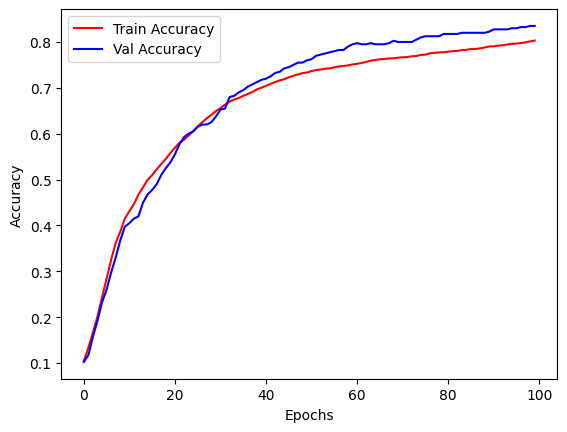

In [ ]:
# Plot training and validation accuracies vs. epochs
epoch = range(len(train_acc))
plt.figure()
plt.plot(epoch, train_acc, 'r', epoch, valid_acc, 'b')
plt.legend(['Train Accuracy', 'Val Accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

**Exercise**

1. Replace the first fully connected layer with a 2D convolution layer and adjust the input size of the remaining fully connected layer so that it fits the new input. Does the performance change?
(try num_filters=16 and filter_size=5 as a starting point).
You can define a conv-layers using the following code:

```
self.conv1 = nn.Conv2d(in_channels=<in_channels>, out_channels=<out_channels>, kernel_size=<kernel_size>)
```

2. After the convolution layer, the size of the input is reduced by `(heigh-1,width-1)` pixels, where `(height,width)` is the filter size. This limits the number of convolutional layers that can be stacked.
Try adding adequate padding to the convolutional layer to retain the spatial dimensions.

3. Try adding more convolution layers and see if you can increase the performance.

4. Increasing the number of convolutions also increases the number of calculations. Try adding a $2\times 2$ max-pool layer after your convolution to decrease the size of the feature-map, while keeping the important features.

    You can define a pooling layer using the following code:

```
self.pool = nn.MaxPool2d(kernel_size=<kernel_size>, stride=<stride>)
```

5. Try experimenting with more convolutional layers and pooling layers and see how it influences the performance.


  <pre>






</pre>

# Let's try using RGB images
## Data: CIFAR-10

The CIFAR-10 dataset (Canadian Institute For Advanced Research) is a collection of images that are commonly used to train machine learning and computer vision algorithms.
You can see it as a "Color-MNIST" dataset.

The CIFAR-10 dataset contains 60,000 32x32 color images in 10 different classes. The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. There are 6,000 images of each class. (https://en.wikipedia.org/wiki/CIFAR-10)

The following code will set up a dataloader that processes images and create mini-batches

In [ ]:
# Load CIFAR-10 and set-up dataloaders. PyTorch has helper-functions for downloading the dataset the first time it is used.
import torch
import torchvision
import torchvision.transforms as transforms

# Transforms are common image transformations, that can be stacked and used for preprocessing images.
# Here, our preprocessing consists of converting the data to torch tensors and normalizing the data
# with 0.5 mean and 0.5 std. diviation for all three channels
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4


# Set up the training set. The data-set helper function already implemented a data-split
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

# Set up the test set. The data-set helper function already implemented a data-split
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

# The CIFAR-10 Classes
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Data visalization
Let's visualize some of the images from CIFAR-10

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

AttributeError: ignored

## Exercise 2.1: Define a simple neural network



__Exercise__: Define a convolutional neural network. Start out with a small network and test that everything is working. Then start adding more layers. Remember that the output should be a vector with 10 indices.
Try adding both conv-layers, pooling layers, fully-connected layers and activations

A reasonable architecture could be:

| Layer type   | size    | Output channels  | Stride |
|--------------|---------|------------------|--------|
| conv         | 5x5     | 6                | 1      |
| pool         | 2x2     |                  | 2      |
| conv         | 5x5     | 16               | 1      |
| fully connected   |      | 120               |       |
| fully connected   |      | 184               |       |
| fully connected   |      | 10               |       |



You can define a conv-layers and pooling layers using the following code:

```
self.conv1 = nn.Conv2d(in_channels=<in_channels>, out_channels=<out_channels>, kernel_size=<kernel_size>)
self.pool = nn.MaxPool2d(kernel_size=<kernel_size>, stride=<stride>)
```

https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html

https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html


In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()

        ## YOUR CODE GOES HERE ##

    def forward(self, x):

        ## YOUR CODE GOES HERE ##

        return x


net = Net()

## Defining a loss-function

Let’s use a Classification Cross-Entropy loss and SGD with momentum.
Our labels are one-hot encoded, which means that for each image, we have a target vector with 10 entries (one for each class).
This target vector contains only zeros except for the entry of the class to which the image belongs.

\begin{equation}
H(y,\hat y) = -\sum_j y_j \cdot log(\hat y_j)
\end{equation}

where

$j=(1,2,...,n_{classes})$ and $\hat y=\begin{cases}
      1 & j=\text{true class}\\
      0 & \text{otherwise}
    \end{cases}     $


In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) # Let's use stocastic gradient descent (We will talk about momentum next week)

## Train the network

This is when things start to get interesting. We simply have to loop over our data iterator, and feed the inputs to the network and optimize.

In [ ]:
nEpocs = 2 # How many times should we run over the data set?

for epoch in range(nEpocs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('Epoch %d, iteration %5d, Train loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))

            running_loss = 0.0

print('Finished Training')

## Save the models

In [ ]:
MODEL_PATH = './cifar_net.pth'
torch.save(net.state_dict(), MODEL_PATH)

## Test the network on the test data

We have trained the network for 2 passes over the training dataset. But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network outputs, and checking it against the ground-truth. If the prediction is correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.

In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

## Loading the model

Let's load the model, we just saved. Since the weights are already set, we don't need this step, but in the future, you can skip the training pass, and just load the weights, you just trained. This is also used when doing _transfer learning_, which will be covered in a future lecture

In [ ]:
net = Net()
net.load_state_dict(torch.load(MODEL_PATH))

## Test the model
Let's classify the images, we just displayed above:

In [ ]:
outputs = net(images)

The output of the network is the raw scores for the 10 classes. In the current network, these scores are unbounded. The higher the score for a class, the more the network thinks that the image is of the particular class. So, let’s get the index of the highest score.

In [ ]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

## How was the results?
Let's iterate through all the test images and see the performance

In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))


# Global average pooling

Recall that global average pooling takes a `(height x width x channels_in)` volume and reduces it to a `channels_in`-dimensional vector by averaging the `height x width` values of each channel.

Thus, we can replace the flatten layer and the first fully connected layer with a `(1 x 1 x channels_out)` convolution, followed by a global average pooling layer.
The cool thing about global average pooling is that it works for all input sizes. If you consider the

**Exercise**
Your task is to replace your flatten layer and first final fully connected layer with global average pooling. In PyTorch, this is called
`nn.AdaptiveAvgPool2d`
https://pytorch.org/docs/stable/generated/torch.nn.AdaptiveAvgPool2d.html

The output of `AdaptiveAvgPool` is still a 3D volume `(1 x 1 x channels_out)`, so you have to reshape it. You can use `x = torch.flatten(x, 1)` after `AdaptiveAvgPool` to convert the output to a 1D vector for each sample.

Now try inputting an image larger than 32x32 pixels.

You can input your own image using this code:

```
im = imageio.imread('horse.jpg').astype(np.float32)
im = torch.from_numpy(im).permute(2,0,1).unsqueeze(0)

transform = transforms.Compose(
    [transforms.Resize((32,32)),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

im = transform(im)
output = net(im)
print(classes[np.argmax(output.detach().numpy())])
```

**Question** The network can only handle input images down to a certain shape (height/width).

 1. Why?
 1. What is the smallest input width/height your model can handle?




# EXTRA: Train on the GPU

If you have a CUDA-enabled computer you can try training the network on the GPU to see a great speed-up. You have to move your network and your variables to the GPU's memory, which you can do by adding the following lines to your code:
```
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)
```

Remember that you will have to send the inputs and targets at every step to the GPU too:
```
inputs.to(device)
labels.to(device)
```

When pulling data from the GPU, use the following commands:
```
myVar.cpu().detach().numpy()
```

# EXTRA: Use your own data
Try training a network on your own classes, e.g., cats and dogs. You can use the following library to scrape images from google image search.
https://pypi.org/project/simple-image-download/

A good starting point is to use the `ImageFolder` dataset, which lets you define an image dataset as folders with names that indicate labels.
https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

You might also have to modify the `transformer`, which preprocesses the images. So far we have only used it to normalize images and convert them to tensors, but it can also be used to resize images (and much more):
```
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize((32,32)),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]).
```